In [94]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [95]:
import numpy as np
import pandas as pd
from scipy.stats import t
from collections import Counter
import matplotlib as mpl
import seaborn as sns
from sklearn import datasets

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

In [93]:
my_seed = 9212
plt = mpl.pyplot

In [9]:
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
 C_min_pow=-4, C_max_pow=3.) :
 fig = plt.figure()
 ax = plt.subplot(111)

 # палитра
 colors = sns.color_palette("Spectral", len(col_names)-1)

 weights, params = [], []
 for c in np.arange(C_min_pow, C_max_pow+1):
  lr = LogisticRegression(penalty=penalty_name,
  C=10.**c, solver='liblinear',
  multi_class='ovr', random_state=my_seed)
  lr.fit(X, y)
  weights.append(lr.coef_[class_number])
  params.append(10**c)
  weights = np.array(weights)
  for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
    label=col_names[column],
    color=color)
    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta',
    linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center',
    bbox_to_anchor=(1.38, 1.03),
    ncol=1, fancybox=True)
    plt.show()


In [10]:
data = pd.read_csv("https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/default_of_credit_card_clients.csv")
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [11]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y'],
      dtype='object')

In [12]:
data.isna().sum()

,0
LIMIT_BAL,0
SEX,0
EDUCATION,0
MARRIAGE,0
AGE,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0
PAY_5,0


In [13]:
cleared_data = data.drop(['PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis=1)
cleared_data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,3913,3102,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,2682,1725,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,29239,14027,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,46990,48233,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,8617,5670,2000,36681,10000,9000,689,679,0


In [17]:
cleared_data['Y'].value_counts()

,count
Y,
0,23364
1,6636


In [14]:
y = cleared_data['Y']
X = cleared_data.drop(['Y'], axis=1)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=my_seed
)

`2. Провести предварительный и корреляционный анализ данных с помощью статистик и
графиков из этой лабораторной.

In [30]:
X.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,51223.330900,49179.075167,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,73635.860576,71173.768783,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,3558.750000,2984.750000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,22381.500000,21200.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,67091.000000,64006.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,964511.000000,983931.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


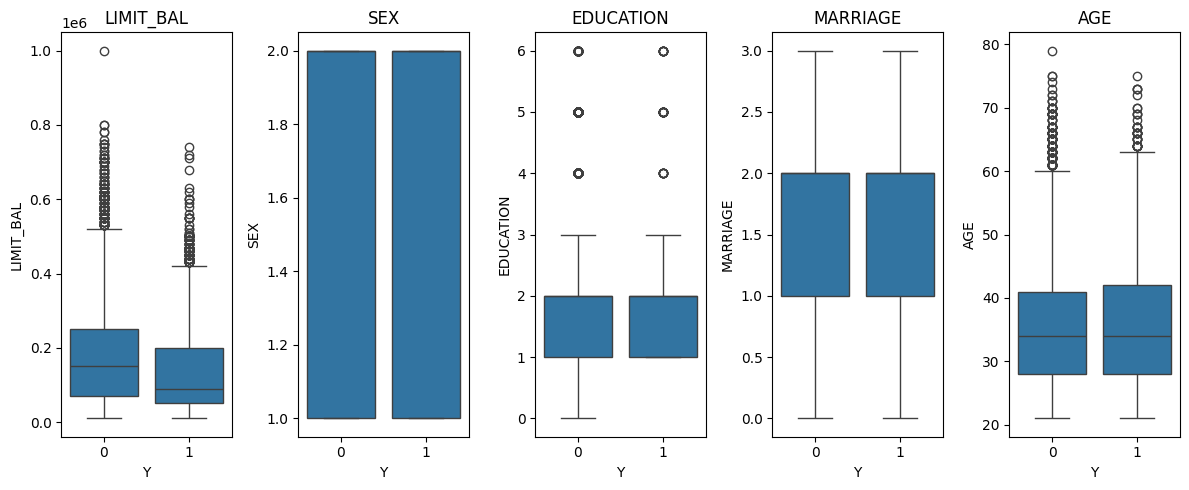

In [33]:
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(cleared_data.columns[:5].values)

for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=cleared_data, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

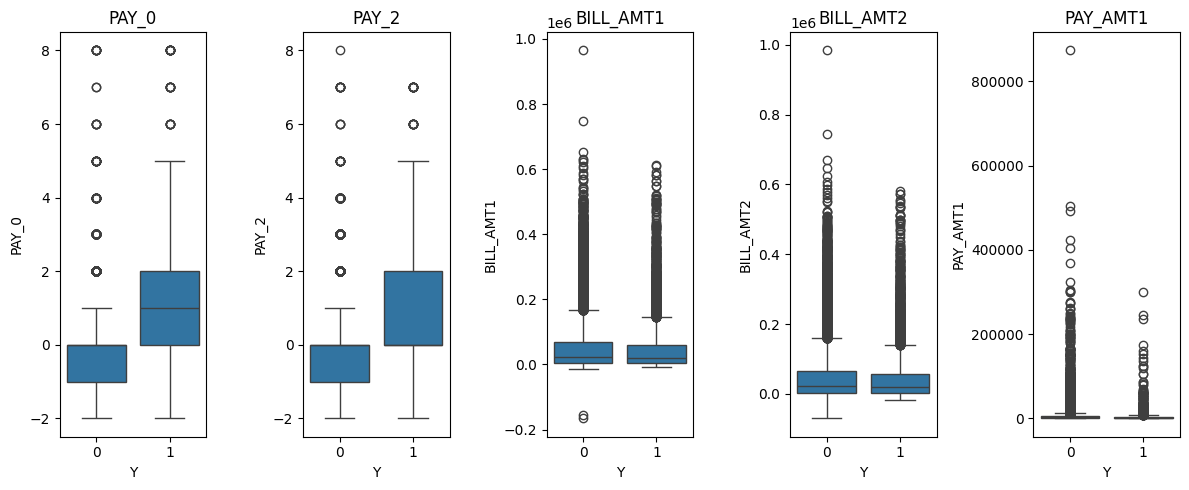

In [34]:
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(cleared_data.columns[5:10].values)

for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=cleared_data, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

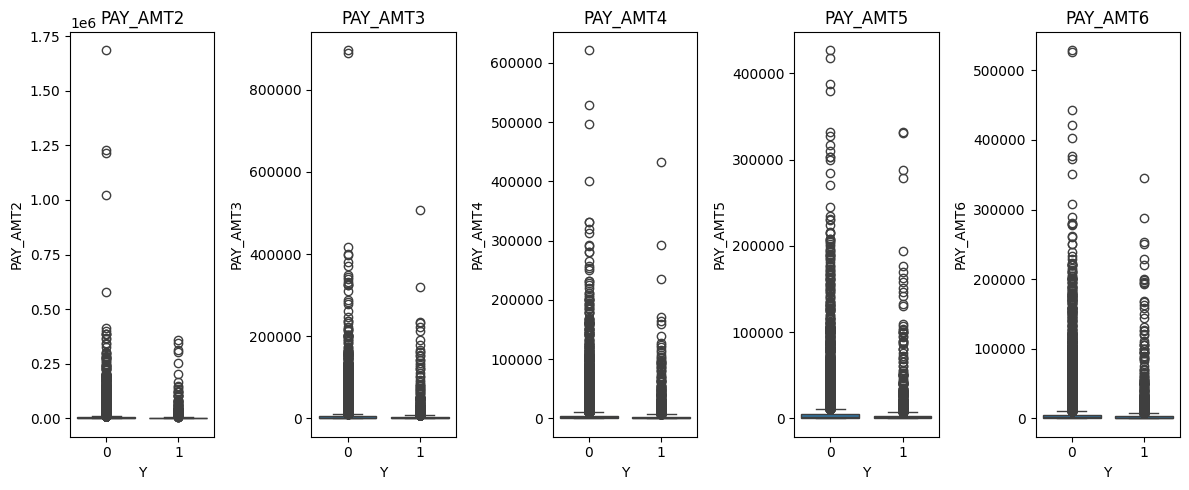

In [35]:
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(cleared_data.columns[10:15].values)

for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=cleared_data, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

<Figure size 1000x800 with 0 Axes>

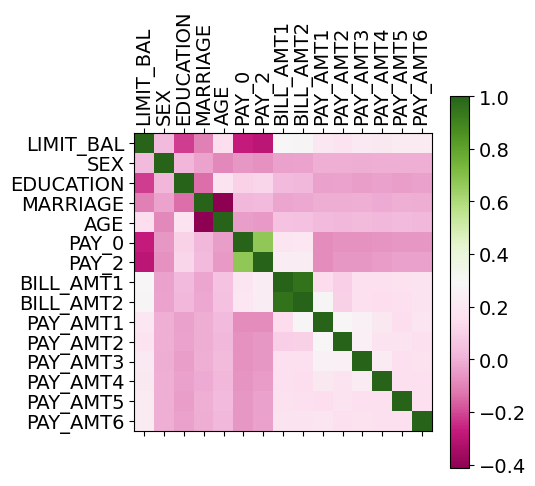

In [39]:
corr_mat = cleared_data.drop('Y', axis=1).corr()
col_names = cleared_data.drop('Y', axis=1).columns


f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, cmap='PiYG')

tics_coords = np.arange(0, len(col_names))

plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()


In [41]:
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))

df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']

t_stat = np.sqrt((len(cleared_data.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(cleared_data.index) - 2))
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
39,MARRIAGE,AGE,-0.414170,0.0
5,LIMIT_BAL,PAY_2,-0.296382,0.0
4,LIMIT_BAL,PAY_0,-0.271214,0.0
1,LIMIT_BAL,EDUCATION,-0.219161,0.0
27,EDUCATION,MARRIAGE,-0.143464,0.0
...,...,...,...,...
84,BILL_AMT2,PAY_AMT1,0.280365,0.0
6,LIMIT_BAL,BILL_AMT1,0.285430,0.0
90,PAY_AMT1,PAY_AMT2,0.285576,0.0
60,PAY_0,PAY_2,0.672164,0.0


Снизить размерность пространства объясняющих переменных методом, указанным в
варианте. Обосновать количество главных компонент. Построить модель логистической
регрессии на преобразованном пространстве объясняющих переменных. Оценить
точность модели методом перекрёстной проверки.

In [47]:
sc = StandardScaler()
X_train_std, X_test_std = sc.fit_transform(X_train), sc.fit_transform(X_train)

X_train_std

array([[-0.90825308,  0.80951017,  0.18388542, ..., -0.17883872,
        -0.215872  , -0.18146368],
       [ 1.09611485, -1.23531493, -1.08377563, ...,  0.31385306,
         0.13983273,  0.02095957],
       [-1.06243523, -1.23531493,  0.18388542, ..., -0.20963196,
        -0.21357713, -0.2096328 ],
       ...,
       [ 0.09393089,  0.80951017,  2.71920751, ..., -0.16732205,
         0.17209204, -0.24625264],
       [ 0.86484163,  0.80951017, -1.08377563, ..., -0.30201166,
        -0.31192867, -0.29414014],
       [ 0.24811303, -1.23531493,  0.18388542, ...,  0.06023996,
         0.06829838,  0.03757935]])

In [50]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train_std)
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
 np.around(frac_var_expl, 3),
 '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.184 0.145 0.101 0.08  0.068 0.06  0.058 0.056 0.056 0.05  0.046 0.038
 0.034 0.021 0.002] 
Общая сумма долей: 1.0


In [51]:
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
1,0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
2,-0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
3,0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
5,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
6,0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
7,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
9,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0


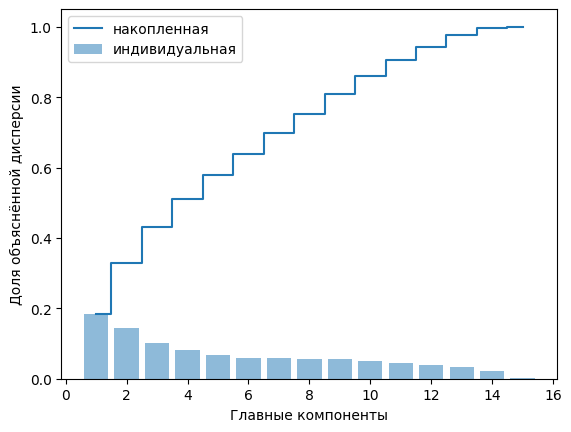

In [54]:
plt.bar(range(1, 16), pca.explained_variance_ratio_, alpha=0.5,
 align='center', label='индивидуальная')
plt.step(range(1, 16), np.cumsum(pca.explained_variance_ratio_),
 where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()


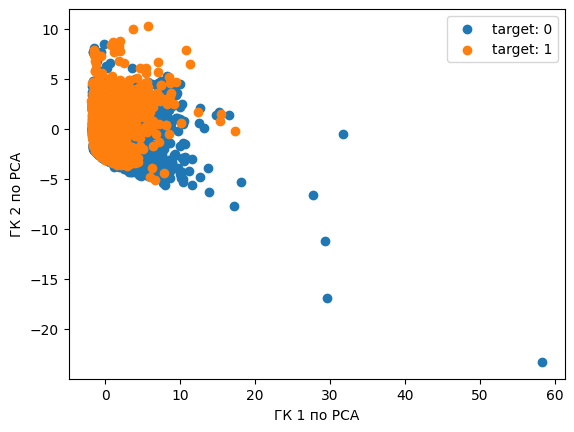

In [65]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)

plt.scatter(X_train_pca[y_train == 0][:, 0],
X_train_pca[y_train == 0][:, 1], label='target: 0')

plt.scatter(X_train_pca[y_train == 1][:, 0],
 X_train_pca[y_train == 1][:, 1], label='target: 1')

plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')

plt.legend()
plt.show()

In [70]:
logit = LogisticRegression()
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)

score = list()
acc = cross_val_score(logit, X_train_pca, y_train, cv=kf_10, scoring='accuracy').mean()
score.append(np.around(acc, 3))

score_models = list()
score_models.append('logit_PC2')

print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
 '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.79


In [72]:
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2, penalty='l2', solver='liblinear')

ridge_cv.fit(X_train_std, y_train)
ridge_cv.C_

array([2.7825594])

In [74]:
score.append(np.around(ridge_cv.score(X_train_std, y_train), 3))
score_models.append('logit_ridge')

print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
 '\nAcc = ', score[1], sep='')

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.809


In [87]:
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names, C_min_pow=-4, C_max_pow=3.) :
  fig = plt.figure()
  ax = plt.subplot(111)
  colors = sns.color_palette("Spectral", len(col_names)-1)

  weights, params = [], []
  for c in np.arange(C_min_pow, C_max_pow+1):
    lr = LogisticRegression(penalty=penalty_name, C=10.**c, solver='liblinear', multi_class='ovr', random_state=my_seed)
    lr.fit(X, y)
    weights.append(lr.coef_[class_number])
    params.append(10**c)

  weights = np.array(weights)

  for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=col_names[column], color=color)

  plt.axvline(x=C_opt[class_number], color='magenta',
  linestyle='--', linewidth=1)

  plt.axhline(0, color='black', linestyle='--', linewidth=1)
  plt.xlim([10**(C_min_pow), 10**C_max_pow])
  plt.ylabel('weight coefficient')
  plt.xlabel('C')
  plt.xscale('log')
  plt.legend(loc='upper left')
  ax.legend(loc='upper center',
  bbox_to_anchor=(1.38, 1.03),
  ncol=1, fancybox=True)
  plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

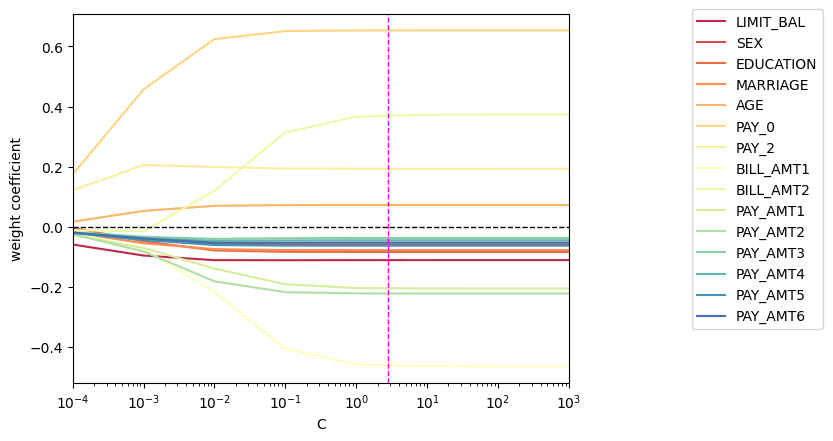

In [88]:
plot_coeffs_traces(X_train_std, y_train, 0, 'l2', ridge_cv.C_, cleared_data.columns)

In [90]:
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PC2,0.792
1,logit_ridge,0.809
2,logit_ridge,0.809


In [92]:
X_test_std = sc.fit_transform(X_test)
y_pred = ridge_cv.predict(X_test_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      4161
           1       0.24      0.73      0.36       339

    accuracy                           0.81      4500
   macro avg       0.61      0.77      0.63      4500
weighted avg       0.92      0.81      0.85      4500

